In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
import graph.random_graph as random_graph
import util.population as population
import util.read_csv as read_csv
import util.gmm as gmm
import core_nn.general_EPIs_dense as general_EPIs_dense
import core_nn.sim as sim
import core_nn.train as train

import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import random
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

[189.06203616 303.96922319  -1.4401702  105.22588382]


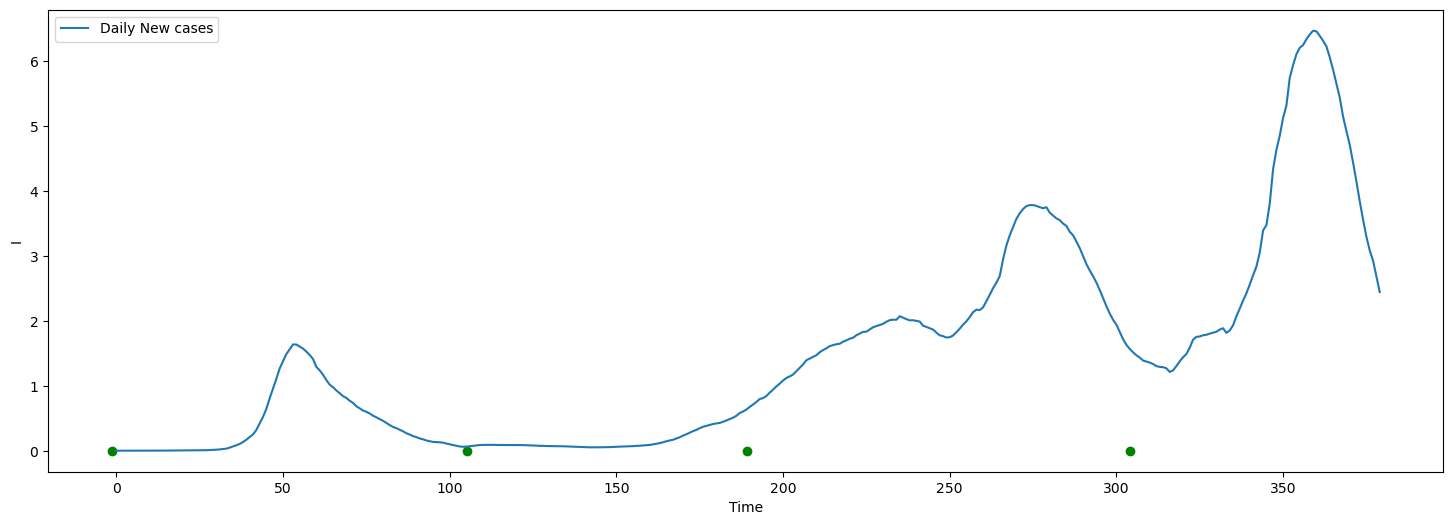

In [7]:
#parameters
n= 1000
avgDegree= 6
timeHorizon= 100
Kn= 4

#read file
csv_file_path = 'spanish.csv'
data= read_csv.read_csv(csv_file_path)
staticNewI= torch.tensor(data["NewI"][20:400], dtype= torch.float32,device= device)*n/1e4

#estimate initial day
timeHorizon= staticNewI.shape[0]
meanT, stdT, weightT= gmm.estimate_days(staticNewI, timeHorizon, Kn, sample_size= 6000)
initDays= meanT- 4*stdT
print(initDays)

#plot
staticNewIPlot= staticNewI.cpu().detach()
plt.figure(figsize=(18,6))
Kn= 4
plt.plot(staticNewIPlot, label="Daily New cases")
plt.scatter(initDays, 0*initDays, color='green', marker='o')
plt.xlabel("Time")
plt.ylabel("I")
plt.legend()


189 377
303 380
0 128
105 338


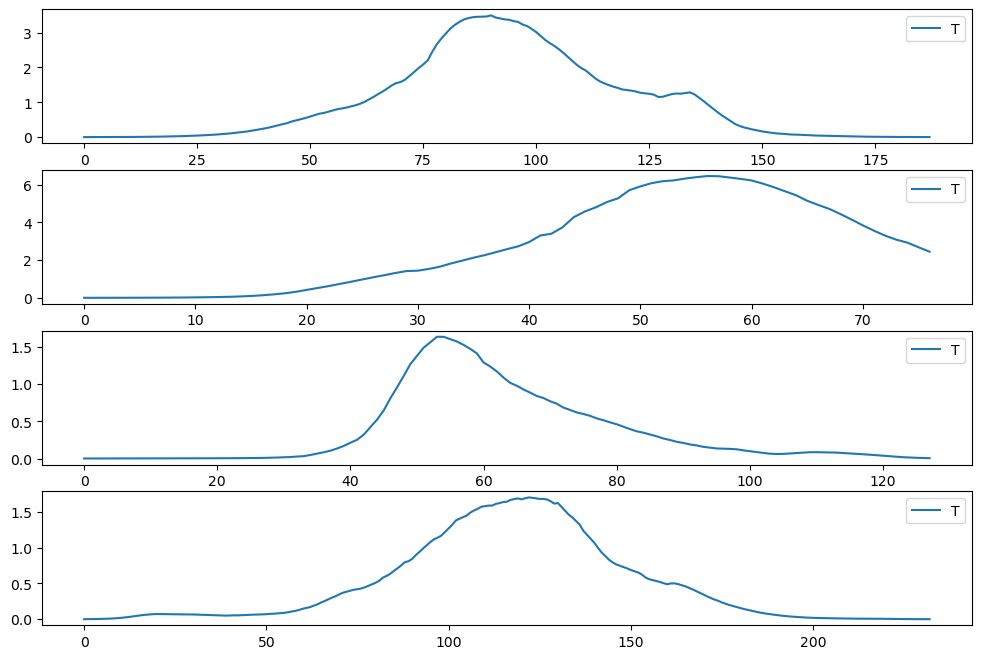

In [8]:
#get proposion
metaStrain= []
preNewIs= []
sumAllNewI= staticNewI.sum()
for i in range(Kn):
    weight= weightT[i]
    variance= stdT[i]**2
    mean= meanT[i]
    upper= staticNewIPlot.shape[0]
    lower= 0
    x_values = np.arange(lower, upper)
    probabilities = (1 / np.sqrt(2 * np.pi * variance)) * np.exp(-(x_values - mean) ** 2 / (2 * variance))
    probabilities= sumAllNewI.item()* weight* probabilities+1e-6
    preNewI= torch.tensor(probabilities, dtype= torch.float32, device=device)
    metaStrain.append(preNewI)
metaStrain= torch.stack(metaStrain)
metaStrain= metaStrain/ metaStrain.sum(dim=0)
staticNewIPlotTemp= staticNewIPlot[None, ...]
metaStrain= staticNewI*metaStrain
# division
fig, axs = plt.subplots(4, 1, figsize=(12, 8))
for i in range(Kn):
    mean=  meanT[i]
    upper= int(mean+4*stdT[i])
    lower= int(mean-4*stdT[i])
    upper= upper if upper< metaStrain.shape[1] else metaStrain.shape[1]
    lower= lower if lower> 0 else 0
    print(lower, upper)
    preNewI= metaStrain[i, lower: upper]
    preNewI.requires_grad_(True)
    preNewIs.append(preNewI)
    axs[i].plot(preNewI.cpu().detach(), label="T")
    axs[i].legend()
plt.show()

In [75]:
sumAllNewI= staticNewI.sum()
preLoss= []
windowSize= 3
bestPsMatrices= []
bestPreLoss= 1e4
psF=  torch.tensor([[0.8, 0.2, 0, 0],
                    [0, 0.5, 0.5, 0],
                    [0, 0, 0.9, 0.1],
                    [0, 0, 0, 1]], device=device)
crossImmMatrixF= torch.tensor([[0, 1.0, 1, 1],
                               [1, 0, 1, 1],
                               [1, 1, 0, 1],
                               [1, 1, 1, 0]], device=device)
contact=random_graph.get_ER_random_contact(n, 4, device=device)
#contact= torch.load(bestContactName).squeeze()
#contact= torch.ones(n, n, dtype= torch.float32, device=device)
MtricesF= torch.stack([psF])
prePsMtricesF= torch.stack([MtricesF]*Kn)
TsF=  torch.tensor([1], dtype= torch.float32, device=device)
preTsF=  torch.stack([TsF]*Kn)
preModelFit= general_EPIs_dense.general_EPIs_dense(contact, prePsMtricesF, crossImmMatrixF, preTsF, device= device, train=True)
preLossFn = torch.nn.MSELoss(reduction='mean')
trainFlag= 0
print(contact.shape)

torch.Size([1000, 1000])


In [79]:

Kn= 1
#contact=random_graph.get_BA_random_contact(n, 2, device=device)
#preModelFit._contact.data= contact[None, None, ...]
if trainFlag==0:
    preOptimizer = torch.optim.Adam([{'params': preModelFit._Ts, 'lr': 1e-1},
                                {'params': preModelFit._psMatrices, 'lr': 4e-3},
                                {'params': preModelFit._crossImmMatrix, 'lr': 0},
                                {'params': preModelFit._trust, 'lr': 0},
                                {'params': preModelFit._contact, 'lr': 0e-3}], lr=1e-3)
elif trainFlag==1:
    preOptimizer = torch.optim.Adam([{'params': preModelFit._Ts, 'lr': 0},
                                {'params': preModelFit._psMatrices, 'lr': 0},
                                {'params': preModelFit._crossImmMatrix, 'lr': 0},
                                {'params': preModelFit._trust, 'lr': 0},
                                {'params': preModelFit._contact, 'lr': 1e-2}], lr=1e-3)
trainFlag=2
for j in tqdm(range(300)):
    datasets= []
    newI0s= []
    dataloaders= []
    oneBatchLoss= 0
    
    for i in range(Kn):
        dataset, newI0= train.generate_dateset(preModelFit, preNewIs[i], preNewIs[i].shape[0], windowSize, Kn= 1, category= i, device=device)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle = True)
        newI0s.append(newI0)
        dataloaders.append(dataloader)
    preOptimizer.zero_grad()
    for i in range(Kn):
        for batch in dataloaders[i]:
            fitY= []
            x, y = batch
            yT= y[:, 0, :]
            timesT= y[:, 1, :]
            x=[x]
            for k in range(windowSize):
                t= timesT[:, k:k+1]
                stateNew, newIt = preModelFit(x[-1], t, category= i)
                statisticI= newIt.squeeze(dim= 1)
                fitY.append(statisticI.sum(dim=1))
                x.append(stateNew)
            yT= yT.T
            fitY= torch.stack(fitY)
            loss= preLossFn(fitY, yT)
            loss.backward(retain_graph=True)
            oneBatchLoss+= loss.item()
    preLoss.append(oneBatchLoss)
    if oneBatchLoss< bestPreLoss:
            bestPs= preModelFit._psMatrices.detach()
            bestContact= preModelFit._contact.detach()
            bestPlot= newI0s[:]
            bestPreLoss= oneBatchLoss
    preOptimizer.step()
    preModelFit._contact.requires_grad_(False)
    preModelFit._contact[preModelFit._contact>1]= 1.0
    preModelFit._contact[preModelFit._contact<=0]= 1e-8#\sum(1-U(1-ICS))= n- \sum(U(1-ICS)) ~=\sum(ICS), if C->(3000, 3000)?
    preModelFit._contact.requires_grad_(True)
    #torch.cuda.empty_cache()
    # if j%99==0:
    #     torch.cuda.empty_cache()
    #     preModelFit._contact.requires_grad_(False)
    #     preModelFit._contact[preModelFit._contact>=1]= 0.999
    #     preModelFit._contact[preModelFit._contact<=0]= 0.001
    #     binary_tensor = torch.bernoulli(preModelFit._contact)
    #     preModelFit._contact.data= binary_tensor
    #     preModelFit._contact.requires_grad_(True)
torch.cuda.empty_cache()

100%|██████████| 300/300 [01:41<00:00,  2.95it/s]


In [80]:
print(preModelFit.beta)
#contact=random_graph.get_BA_random_contact(n, 2, device=device)
#preModelFit._contact.data= contact[None, None, ...]
print(preModelFit._mysoftmax(preModelFit._psMatrices[0, ...]+preModelFit._mask1))
#preModelFit._psMatrices.data= bestPs
print(contact[ 0, 0: 10])

1
tensor([[[8.6784e-01, 1.3216e-01, 7.0065e-45, 7.0065e-45],
         [7.0065e-45, 8.7400e-01, 1.2600e-01, 7.0065e-45],
         [1.1210e-44, 1.1210e-44, 3.8686e-01, 6.1314e-01],
         [1.4013e-44, 1.4013e-44, 1.4013e-44, 1.0000e+00]]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08,
        1.0000e-08, 1.0000e-08, 1.0000e-08, 1.0000e-08], device='cuda:0')


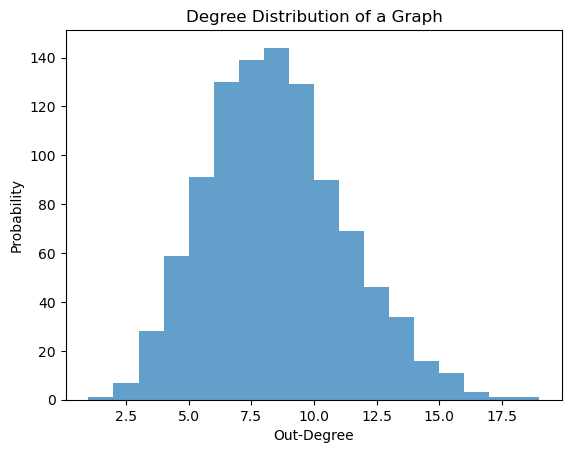

In [81]:
torch.cuda.empty_cache()
# preModelFit._contact.requires_grad_(False)
# preModelFit._contact[preModelFit._contact>=1]= 0.999
# preModelFit._contact[preModelFit._contact<=0]= 0.001
# binary_tensor = torch.bernoulli(preModelFit._contact)
# preModelFit._contact.data= binary_tensor
# preModelFit._contact.requires_grad_(True)
import networkx as nx
torch.cuda.empty_cache()
contactPrint= preModelFit._contact.squeeze().cpu().detach().numpy()
contactPrint[contactPrint<0e-1]=0
G = nx.from_numpy_matrix(contactPrint, create_using=nx.DiGraph)
# Calculate the out-degree sequence
out_degrees = dict(G.in_degree(weight='weight'))
degree_values = list(out_degrees.values())
# Plot the degree distribution
plt.hist(degree_values, bins=range(int(min(degree_values)), int(max(degree_values)) + 1), alpha=0.7)
#print(out_degrees.values())
plt.title("Degree Distribution of a Graph")
plt.xlabel("Out-Degree")
plt.ylabel("Probability")
plt.show()

Parameter containing:
tensor([[[4.1085]]], device='cuda:0', requires_grad=True)


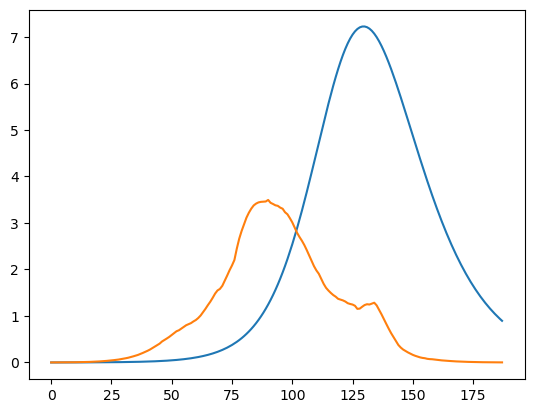

In [82]:

print(preModelFit._Ts)
i= 0
dataset, newI0= train.generate_dateset(preModelFit, preNewIs[i], preNewIs[i].shape[0], windowSize, Kn= 1, category=i,  device=device)
torch.cuda.empty_cache()
plt.plot(newI0.cpu().detach())
plt.plot(preNewIs[i].cpu().detach())

Text(0, 0.5, 'loss')

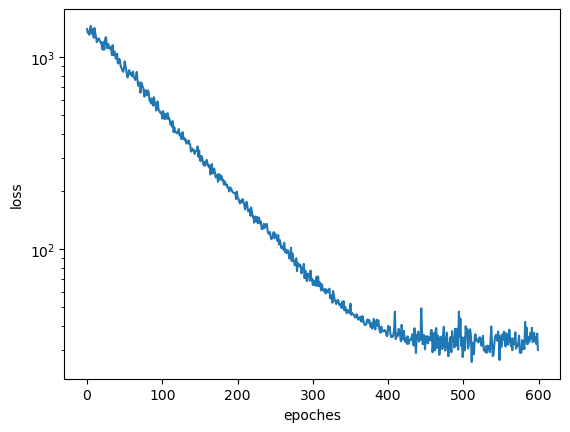

In [83]:
#bestPsMatricesTensor= torch.stack(bestPsMatrices)
#bestPsMatricesTensor= bestPsMatricesTensor.transpose(dim= 0)
plt.plot(preLoss)
plt.yscale("log")
plt.xlabel("epoches")
plt.ylabel("loss")

In [39]:
bestContactName= "BC.pth"
torch.save(bestContact.data, bestContactName)